# Tutorial 6
We show how to train Double DQN for high frequency trading on Bitcoin.

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions 

In [17]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot

## Step 2: Load Configs
Load default config from the file `configs/high_frequency_trading/high_frequency_trading_BTC_dqn_dqn_adam_mse.py`

In [18]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "high_frequency_trading", "high_frequency_trading_BTC_dqn_dqn_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")

args, _ = parser.parse_known_args()
cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [19]:
cfg

Config (path: E:\workspace\RA\TradeMaster\configs\high_frequency_trading\high_frequency_trading_BTC_dqn_dqn_adam_mse.py): {'data': {'type': 'HighFrequencyTradingDataset', 'data_path': 'data/high_frequency_trading/small_BTC', 'train_path': 'data/high_frequency_trading/small_BTC/train.csv', 'valid_path': 'data/high_frequency_trading/small_BTC/valid.csv', 'test_path': 'data/high_frequency_trading/small_BTC/test.csv', 'test_dynamic_path': 'data/high_frequency_trading/small_BTC/test_labeled_3_300_-0.01_0.01.csv', 'tech_indicator_list': ['imblance_volume_oe', 'sell_spread_oe', 'buy_spread_oe', 'kmid2', 'bid1_size_n', 'ksft2', 'ma_10', 'ksft', 'kmid', 'ask1_size_n', 'trade_diff', 'qtlu_10', 'qtld_10', 'cntd_10', 'beta_10', 'roc_10', 'bid5_size_n', 'rsv_10', 'imxd_10', 'ask5_size_n', 'ma_30', 'max_10', 'qtlu_30', 'imax_10', 'imin_10', 'min_10', 'qtld_30', 'cntn_10', 'rsv_30', 'cntp_10', 'ma_60', 'max_30', 'qtlu_60', 'qtld_60', 'cntd_30', 'roc_30', 'beta_30', 'bid4_size_n', 'rsv_60', 'ask4_size

## Step 3: Build Dataset

In [20]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments
Build environments based on cfg and predefined dataset



In [21]:
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))
cfg.environment = cfg.train_environment
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))

In [22]:
train_environment.df.head()

,bid1_price,bid1_size,bid2_price,bid2_size,bid3_price,bid3_size,bid4_price,bid4_size,bid5_price,bid5_size,...,imxd_60,cntp_10,cntp_30,cntp_60,cntn_10,cntn_30,cntn_60,cntd_10,cntd_30,cntd_60
0,23794.3,0.900828,23792.9,0.018588,23792.8,0.007388,23792.1,0.042018,23792.0,0.000300,...,1.193895,0.268138,0.963686,0.800684,-0.418841,-0.017993,-0.189727,0.469470,0.745885,0.877378
1,23794.3,0.000878,23793.2,0.014988,23793.1,0.147063,23792.8,0.007388,23792.0,0.000300,...,1.193895,0.268138,0.963686,0.800684,-1.027695,-0.017993,-0.358007,0.891105,0.745885,1.031828
2,23794.3,0.000878,23793.2,0.014988,23792.8,0.007388,23792.0,0.000300,23791.8,0.147071,...,1.139902,0.268138,1.257798,0.976534,-1.027695,-0.017993,-0.526286,0.891105,0.969180,1.340727
3,23794.3,0.000878,23793.2,0.014988,23792.8,0.007388,23792.0,0.000300,23791.8,0.147071,...,1.139902,0.268138,1.257798,0.800684,-1.027695,-0.017993,-0.526286,0.891105,0.969180,1.186278
4,23794.3,0.000878,23793.2,0.014988,23792.8,0.007388,23792.0,0.000300,23791.8,0.147071,...,1.112905,0.268138,0.963686,0.800684,-1.027695,-0.017993,-0.694566,0.891105,0.745885,1.340727


## Step 5: Build Net 
Update information about the state and action dimension. Create networks and optimizer for Double DQN


In [25]:
action_dim = train_environment.action_dim
state_dim = train_environment.state_dim

cfg.act.update(dict(action_dim=action_dim, state_dim=state_dim))
act = build_net(cfg.act)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
if cfg.cri:
    cfg.cri.update(dict(action_dim=action_dim, state_dim=state_dim))
    cri = build_net(cfg.cri)
    cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))
else:
    cri = None
    cri_optimizer = None

## Step 6: Build Loss

In [26]:
criterion = build_loss(cfg)

## Step 7: Build Agent

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg,default_args=dict(action_dim=action_dim,state_dim=state_dim,act=act,cri=cri,act_optimizer=act_optimizer,cri_optimizer=cri_optimizer,criterion=criterion,device=device))


## Step 8: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [28]:

trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))

cfg.dump(osp.join(ROOT, cfg.work_dir, osp.basename(args.config)))

| Arguments Keep work_dir: E:\workspace\RA\TradeMaster\work_dir/high_frequency_trading_BTC_high_frequency_trading_dqn_ddqn_adam_mse


## Step 9: RL Agent Training
Train the Double DQN agent based on the config and save results in workdir

In [29]:
trainer.train_and_valid()

Train Episode: [1/10]
+---------------+----------------+------------+--------------+
| Profit Margin |  Sharp Ratio   | Volatility | Max Drawdown |
+---------------+----------------+------------+--------------+
|  -19.824600%  | -239691.192267 | 0.003871%  |  19.845428%  |
+---------------+----------------+------------+--------------+
+---------------+----------------+------------+--------------+
| Profit Margin |  Sharp Ratio   | Volatility | Max Drawdown |
+---------------+----------------+------------+--------------+
|  -19.917355%  | -215706.416383 | 0.004321%  |  19.921304%  |
+---------------+----------------+------------+--------------+
Valid Episode: [1/10]
+--------------+----------------+------------+--------------+
| Total Return |  Sharp Ratio   | Volatility | Max Drawdown |
+--------------+----------------+------------+--------------+
| -40.916735%  | -239529.278864 | 0.006067%  |  40.921548%  |
+--------------+----------------+------------+--------------+
Train Episode: [

## Step 10: RL Agent Testing

In [30]:
trainer.test()

Resume checkpoint E:\workspace\RA\TradeMaster\work_dir/high_frequency_trading_BTC_high_frequency_trading_dqn_ddqn_adam_mse\checkpoints\best.pth
Test Best Episode
+--------------+----------------+------------+--------------+
| Total Return |  Sharp Ratio   | Volatility | Max Drawdown |
+--------------+----------------+------------+--------------+
| -50.842218%  | -278960.325993 | 0.006473%  |  50.842218%  |
+--------------+----------------+------------+--------------+


array([ 0.        , -0.01565856, -0.016     , ..., -0.0114849 ,
       -0.05748495, -0.01465415])

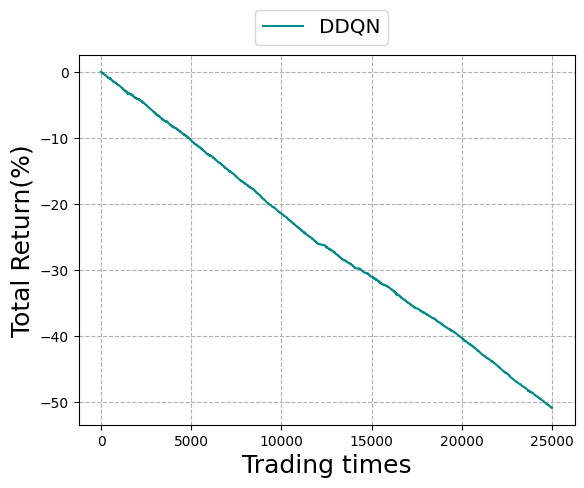

In [31]:
plot(trainer.test_environment.save_asset_memoey(),alg="DDQN")